## Text Mining

In [100]:
import pandas as pd
import os
import glob

### Loading Text Data from directory


In [101]:
# Read all files in the directory and combine then into file named corpus 
file_list = glob.glob(os.path.join(os.getcwd(), "CaseStudy2Data\datasets", "*.txt"))
corpus = []
for file_path in file_list:
    with open(file_path) as f_input:
        corpus.append(f_input.read())
 
#print(corpus)

# Convert the corpus list into a data frame
df = pd.DataFrame(corpus, columns= ['Text'],)
df2 = pd.DataFrame(df.Text.str.split('\n\n', n = 2).tolist(), columns = ['Title', 'Abstract', 'Text'])
df2.head(10)

,Title,Abstract,Text
0,Claxton hunting first major medal,British hurdler Sarah Claxton is confident she...,The 25-year-old has already smashed the Britis...
1,O'Sullivan could run in Worlds,Sonia O'Sullivan has indicated that she would ...,Athletics Ireland have hinted that the 35-year...
2,Greene sets sights on world title,Maurice Greene aims to wipe out the pain of lo...,He had to settle for bronze in Greece behind f...
3,IAAF launches fight against drugs,The IAAF - athletics' world governing body - h...,Two task forces have been set up to examine do...
4,"Dibaba breaks 5,000m world record",Ethiopia's Tirunesh Dibaba set a new world rec...,Dibaba won in 14 minutes 32.93 seconds to eras...
5,Isinbayeva claims new world best,Pole vaulter Yelena Isinbayeva broke her own i...,It was the Russian's 12th world record of her ...
6,O'Sullivan commits to Dublin race,Sonia O'Sullivan will seek to regain her title...,The 35-year-old was beaten into fourth at last...
7,Hansen 'delays return until 2006',British triple jumper Ashia Hansen has ruled o...,"Hansen, the Commonwealth and European champion..."
8,Off-colour Gardener storms to win,Britain's Jason Gardener shook off an upset st...,Gardener clocked 6.56 seconds to equal the mee...
9,Collins to compete in Birmingham,World and Commonwealth 100m champion Kim Colli...,The St Kitts and Nevis star joins British Olym...


In [103]:
# random state
rs = 42
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
Title       200 non-null object
Abstract    200 non-null object
Text        200 non-null object
dtypes: object(3)
memory usage: 4.8+ KB


In [133]:
# print out the first 200 characters of the first row of text column
print(df2.get_value(index=0, col = 'Text')[:200])

The 25-year-old has already smashed the British record over 60m hurdles twice this season, setting a new mark of 7.96 seconds to win the AAAs title. "I am quite confident," said Claxton. "But I take e


D:\Programs\conda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [134]:
# average length of text column
print("Average length of the data: ", df2['Text'].apply(lambda x: len(x)).mean())

# Minimum length of text column
print("Minimum length of the data: ", df2['Text'].apply(lambda x: len(x)).min())

# Maximum length of text column
print("Maximum length of the data: ", df2['Text'].apply(lambda x: len(x)).max())

Average length of the data:  1773.025
Minimum length of the data:  479
Maximum length of the data:  9581


### Data Prepocessing

In [106]:
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

In [157]:
# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

# load the provided stopwords
df_stop = pd.read_json('CaseStudy2Data\Federaliststop.json')

# join provided stopwords with the default NLTK English stopwords
stopwords = set(df_stop['Term']).union(set(sw.words('english')))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

In [158]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df2['Text'])

# see the number of unique tokens produced by the vectorizer. Lots of them...
print(len(tfidf_vec.get_feature_names()))

28495


### Initial Document Analysis

In [161]:
from sklearn.cluster import KMeans

# K means clustering using the term vector
#kmeans = KMeans(n_clusters=7, random_state=rs).fit(X)
kmeans = KMeans(n_clusters=7, random_state=rs).fit(X)

In [199]:
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :10]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: ball, cricket, wicket, pakistan, australia, run, test, strauss, england, icc, 
Top terms for cluster 1: season, play, game, injury, villa, 17, clijsters, australian, capriati, year, 
Top terms for cluster 2: 6, roddick, 7, win, year, hewitt, set, play, 3, final, 
Top terms for cluster 3: club, want, player, liverpool, madrid, â £, £, â, play, benitez, 
Top terms for cluster 4: paula, world, marathon, radcliffe, year, cross, compete, chepkemei, event, world cross, 
Top terms for cluster 5: england, ireland, wale, game, win, back, goal, team, kick, nation, 
Top terms for cluster 6: drug, athlete, iaaf, athletics, test, balco, greek, ban, olympics, kenteris, 


###  Feature Selection and Transformation
####  Zipf's Law and Document Frequency Filtering

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df2['Text'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    #print(count_vec.get_feature_names())
    #print(len(count_vec.get_feature_names()))
    return terms
    
terms = calculate_tf_idf_terms(df2['Text'])

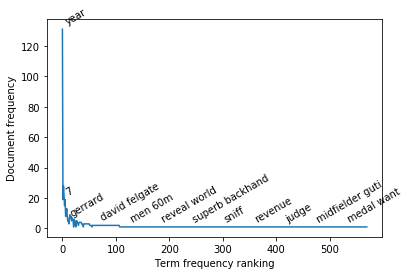

In [164]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
visualise_zipf(terms)

In [165]:
print("The top 10 terms with high tf and df")
terms[:10]

The top 10 terms with high tf and df


[{'term': 'year', 'idx': 28198, 'tf': 288, 'df': 131},
 {'term': 'game', 'idx': 10951, 'tf': 236, 'df': 102},
 {'term': 'play', 'idx': 19252, 'tf': 228, 'df': 100},
 {'term': 'win', 'idx': 27550, 'tf': 215, 'df': 98},
 {'term': 'one', 'idx': 18176, 'tf': 184, 'df': 99},
 {'term': 'england', 'idx': 8858, 'tf': 163, 'df': 46},
 {'term': 'make', 'idx': 15817, 'tf': 156, 'df': 105},
 {'term': 'world', 'idx': 27932, 'tf': 155, 'df': 84},
 {'term': 'player', 'idx': 19411, 'tf': 153, 'df': 81},
 {'term': 'would', 'idx': 28004, 'tf': 149, 'df': 91}]

In [166]:
# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 2 documents and max 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.8)
X_filter = filter_vec.fit_transform(df2['Text'])

# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

5209


This process greatly reduced the number of terms in a feature set. Try to build another clustering solution and check if the clusters are more meaningful.

In [167]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
#kmeans_fil = KMeans(n_clusters=7, random_state=rs).fit(X_filter)
kmeans_fil = KMeans(n_clusters=7, random_state=rs).fit(X_filter)


Wall time: 949 ms


In [168]:
# visualisation
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names())

Top terms for cluster 0: hewitt, win, grand slam, slam, grand, 
Top terms for cluster 1: 6, 7, roddick, moya, 3, 
Top terms for cluster 2: world, year, olympic, athletics, athlete, 
Top terms for cluster 3: arsenal, henry, club, chelsea, player, 
Top terms for cluster 4: england, cricket, play, game, rugby, 
Top terms for cluster 5: ball, wicket, run, vaughan, strauss, 
Top terms for cluster 6: club, game, liverpool, want, manager, 


### Clustering with filtered terms

In [169]:
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(1, 30, 3):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=-10)
    model.fit(X_filter)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

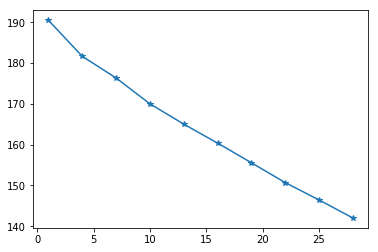

In [170]:
# plot the inertia vs K values
plt.plot(range(1,30,3), inertia_vals, marker='*')
plt.show()

In [171]:
#Get optimum clusters

from sklearn.metrics import silhouette_score

print(clusters[1])
print("Silhouette score for k=3", silhouette_score(X, clusters[1].predict(X_filter)))
print('\n')

print(clusters[2])
print("Silhouette score for k=6", silhouette_score(X, clusters[2].predict(X_filter)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=3 0.009725082025277314


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=-10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 0.011697290987505543


In [175]:
# best cluster number k = 6
kmeans_fil2 = KMeans(n_clusters=7, random_state=rs).fit(X_filter)
# visualisation
visualise_text_cluster(kmeans_fil2.n_clusters, kmeans_fil2.cluster_centers_, filter_vec.get_feature_names())

Top terms for cluster 0: hewitt, win, grand slam, slam, grand, 
Top terms for cluster 1: 6, 7, roddick, moya, 3, 
Top terms for cluster 2: world, year, olympic, athletics, athlete, 
Top terms for cluster 3: arsenal, henry, club, chelsea, player, 
Top terms for cluster 4: england, cricket, play, game, rugby, 
Top terms for cluster 5: ball, wicket, run, vaughan, strauss, 
Top terms for cluster 6: club, game, liverpool, want, manager, 


#### Singular Value Decomposition

In [191]:
from sklearn.decomposition import TruncatedSVD

#svd = TruncatedSVD(n_components=100, random_state=42)
svd = TruncatedSVD(n_components=100, random_state=42)
X_trans = svd.fit_transform(X_filter)

In [192]:
# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = filter_vec.get_feature_names()

# visualise word - concept/component relationships
for comp_num in range(6):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :10]:
        print(terms[i], end=", ")
    print()
print(len(sorted_comp))

Top terms in component #0 year, play, game, england, win, 6, team, player, world, would, 
Top terms in component #1 6, 7, roddick, hewitt, 3, 7 6, moya, 6 7, set, federer, 
Top terms in component #2 ball, wicket, england, strauss, run, 6, trescothick, inning, vaughan, jones, 
Top terms in component #3 world, drug, athletics, test, athlete, olympic, ban, iaaf, marathon, indoor, 
Top terms in component #4 england, ireland, wale, nation, france, hodgson, six nation, williams, kick, rugby, 
Top terms in component #5 arsenal, chelsea, shot, henry, indoor, record, goal, finish, bekele, minute, 
100


In [197]:
%%time
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=6, random_state=rs).fit(X_trans)

Wall time: 33.9 ms


In [200]:
# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names())

Top terms for cluster 0: world, year, paula, radcliffe, marathon, record, cross, indoor, bekele, 000m, 
Top terms for cluster 1: 6, roddick, 7, hewitt, win, year, set, federer, final, moya, 
Top terms for cluster 2: drug, athlete, iaaf, test, athletics, balco, greek, 200m, medal, ban, 
Top terms for cluster 3: game, play, player, club, want, team, would, england, year, cricket, 
Top terms for cluster 4: england, ireland, hodgson, nation, france, wale, six nation, six, lewsey, win, 
Top terms for cluster 5: wale, bath, rugby, williams, tindall, henson, zealand, tour, mike, welsh, 


In [210]:
terms = calculate_tf_idf_terms(X_trans)
print("The top 15 terms")
terms[:15]

The top 15 terms


[{'term': '25', 'idx': 739, 'tf': 23, 'df': 19},
 {'term': 'year', 'idx': 28198, 'tf': 288, 'df': 131},
 {'term': 'old', 'idx': 18031, 'tf': 86, 'df': 73},
 {'term': 'smash', 'idx': 23458, 'tf': 6, 'df': 6},
 {'term': 'record', 'idx': 20662, 'tf': 44, 'df': 31},
 {'term': '60m', 'idx': 1190, 'tf': 12, 'df': 7},
 {'term': 'hurdle', 'idx': 13008, 'tf': 6, 'df': 4},
 {'term': 'season', 'idx': 22252, 'tf': 88, 'df': 52},
 {'term': 'set', 'idx': 22687, 'tf': 123, 'df': 66},
 {'term': 'mark', 'idx': 16127, 'tf': 49, 'df': 33},
 {'term': '7', 'idx': 1236, 'tf': 60, 'df': 19},
 {'term': '96', 'idx': 1404, 'tf': 1, 'df': 1},
 {'term': 'second', 'idx': 22339, 'tf': 122, 'df': 76},
 {'term': 'win', 'idx': 27550, 'tf': 215, 'df': 98},
 {'term': 'aaas', 'idx': 1414, 'tf': 1, 'df': 1}]

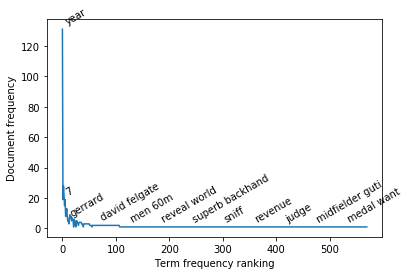

In [209]:
visualise_zipf(terms)